In [1]:
import os
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import numpy as np
from skimage import color
from skimage import io
import pandas as pd
from PIL import Image
import collections
import cv2

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [3]:
def to_index(name):
    return int(name[:6])

In [4]:
def to_name(index):
    name = ''
    for i in range(6 - len(str(index))):
        name += '0'
    name = name + str(index) + '.jpg'
    return name

In [5]:
def load_images_from_folder(folder):
    images = {}
    sizes = {}
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder,filename))
        if img is not None: 
            sizes[to_index(filename)] = img.size  
            new_img = img.resize((128,128), Image.ANTIALIAS)
            temp = rgb2gray(np.array(new_img))
            images[to_index(filename)] = temp   
    return images, sizes

In [6]:
def load_rgb_images_from_folder(folder):
    images = {}
    sizes = {}
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder,filename))
        if img is not None: 
            sizes[to_index(filename)] = img.size  
            new_img = img.resize((128,128), Image.ANTIALIAS)
            images[to_index(filename)] = new_img   
    return images, sizes

In [7]:
def change_bbox(name, old_w, old_h, df):
    df.at[to_index(name)-1, 'x_1'] *= (128/old_w)
    df.at[to_index(name)-1, 'y_1'] *= (128/old_h)
    df.at[to_index(name)-1, 'width'] *= (128/old_w)
    df.at[to_index(name)-1, 'height'] *= (128/old_h)

In [ ]:
folder_name = '../../Data/5000/'
train_imgs, old_sizes= load_images_from_folder(folder_name)

In [8]:
folder_name = '../../Data/Part 1/Part 1'
train_imgs1, old_sizes1= load_rgb_images_from_folder(folder_name)

In [9]:
folder_name = '../../Data/Part 2/Part 2'
train_imgs2, old_sizes2= load_rgb_images_from_folder(folder_name)

In [68]:
folder_name = '../../Data/Part 3/Part 3'
train_imgs3, old_sizes3= load_rgb_images_from_folder(folder_name)

In [100]:
folder_name = '../../Data/Part 4/Part 4'
train_imgs4, old_sizes4= load_rgb_images_from_folder(folder_name)

In [101]:
train_imgs = { **train_imgs1, **train_imgs2, **train_imgs3, **train_imgs4}
old_sizes = { **old_sizes1, **old_sizes2, **old_sizes3, **old_sizes4}

In [74]:
train_imgs = { **train_imgs1, **train_imgs2, **train_imgs3}
old_sizes = { **old_sizes1, **old_sizes2, **old_sizes3}

In [10]:
train_imgs = { **train_imgs1, **train_imgs2}

In [11]:
old_sizes = { **old_sizes1, **old_sizes2}

In [102]:
od = collections.OrderedDict(sorted(train_imgs.items())) #ordered dict

In [103]:
df = pd.read_csv('../../Data/list_bbox_celeba.csv')

In [104]:
for i in od.keys():
    img_number = i
    change_bbox(to_name(img_number), old_sizes[img_number][0], old_sizes[img_number][1], df)

In [105]:
max(od.keys())

40000

In [106]:
tst = []
for i in range(1,40000):
    tst.append(np.array(od[i]))

In [107]:
X_train = np.array(tst[:35000])
X_val = np.array(tst[35000:37500])
X_test = np.array(tst[37500:])
Y_train = np.array(df.drop(columns=['image_id'],axis = 1)[:35000])
Y_val = np.array(df.drop(columns=['image_id'],axis = 1)[35000:37500])
Y_test = np.array(df.drop(columns=['image_id'],axis = 1)[37500:40000])

In [33]:
X_train = np.array(tst[:16000])
X_val = np.array(tst[16000:18000])
X_test = np.array(tst[18000:])
Y_train = np.array(df.drop(columns=['image_id'],axis = 1)[:16000])
Y_val = np.array(df.drop(columns=['image_id'],axis = 1)[16000:18000])
Y_test = np.array(df.drop(columns=['image_id'],axis = 1)[18000:20000])

In [24]:
X_train = X_train / 256
X_val = X_val / 256
X_test = X_test / 256
Y_train = Y_train / 256
Y_val = Y_val / 256
Y_test = Y_test / 256

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [35]:
model = keras.Sequential()
model.add(keras.Input(shape=(128, 128, 3)))
model.add(layers.Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding="valid"))
model.add(layers.PReLU(shared_axes=[1, 2]))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same"))

model.add(layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="valid"))
model.add(layers.PReLU(shared_axes=[1, 2]))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))

model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding="valid"))
model.add(layers.PReLU(shared_axes=[1, 2]))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

model.add(layers.Conv2D(64, kernel_size=(2, 2), strides=(1, 1), padding="valid"))
model.add(layers.PReLU(shared_axes=[1, 2]))

model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.PReLU())

model.add(layers.Dense(4))

model.summary()
model.compile('adadelta', loss='mse')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
p_re_lu_20 (PReLU)           (None, 126, 126, 16)      16        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 61, 61, 32)        4640      
_________________________________________________________________
p_re_lu_21 (PReLU)           (None, 61, 61, 32)        32        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 64)       

In [29]:
X_train[21111]/256

array([[[0.83203125, 0.61328125, 0.375     ],
        [0.828125  , 0.61328125, 0.375     ],
        [0.82421875, 0.61328125, 0.37890625],
        ...,
        [0.8046875 , 0.578125  , 0.328125  ],
        [0.78515625, 0.55859375, 0.3125    ],
        [0.75390625, 0.5390625 , 0.296875  ]],

       [[0.83203125, 0.61328125, 0.375     ],
        [0.83203125, 0.6171875 , 0.375     ],
        [0.828125  , 0.6171875 , 0.3828125 ],
        ...,
        [0.8046875 , 0.578125  , 0.328125  ],
        [0.796875  , 0.5703125 , 0.32421875],
        [0.7578125 , 0.54296875, 0.30078125]],

       [[0.82421875, 0.60546875, 0.3671875 ],
        [0.82421875, 0.60546875, 0.3671875 ],
        [0.81640625, 0.60546875, 0.375     ],
        ...,
        [0.796875  , 0.5703125 , 0.3203125 ],
        [0.78125   , 0.55078125, 0.30859375],
        [0.7421875 , 0.52734375, 0.28515625]],

       ...,

       [[0.08984375, 0.24609375, 0.26953125],
        [0.06640625, 0.2109375 , 0.23828125],
        [0.0546875 , 0

In [108]:
model.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val), verbose=1, batch_size=64)

Epoch 1/10
547/547 [==============================] - 367s 671ms/step - loss: 179.1267 - val_loss: 180.9631
Epoch 2/10
547/547 [==============================] - 390s 713ms/step - loss: 177.4115 - val_loss: 179.0725
Epoch 3/10
547/547 [==============================] - 392s 717ms/step - loss: 175.8038 - val_loss: 177.9358
Epoch 4/10
547/547 [==============================] - 395s 722ms/step - loss: 174.3162 - val_loss: 175.8967
Epoch 5/10
547/547 [==============================] - 397s 725ms/step - loss: 172.9896 - val_loss: 175.2451
Epoch 6/10
547/547 [==============================] - 396s 724ms/step - loss: 171.5170 - val_loss: 175.6620
Epoch 7/10
547/547 [==============================] - 398s 727ms/step - loss: 170.3775 - val_loss: 172.3548
Epoch 8/10
547/547 [==============================] - 398s 728ms/step - loss: 169.1108 - val_loss: 171.4509
Epoch 9/10
547/547 [==============================] - 399s 730ms/step - loss: 167.9158 - val_loss: 169.9298
Epoch 10/10
547/547 [=======

In [109]:
y_pred = model.predict(X_test)

In [ ]:
def custom_loss(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return tf.summary.scalar('name', 1, step=None, description=None)

    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return tf.summary.scalar('name', 1 - I / U, step=None, description=None)


In [30]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

In [31]:
def calc_accuracy(y_pred, y_test):
    tmp = []
    for i in range(len(y_pred)):
        tmp.append(IOU(y_pred[i], y_test[i]))
    
    return np.average(tmp)
    

In [110]:
calc_accuracy(y_pred, Y_test)

0.5195608109954712

In [87]:
y_pred[1]

array([17.511404, 15.3977  , 47.957314, 42.20073 ], dtype=float32)

In [88]:
Y_test[1]

array([28, 20, 75, 80])

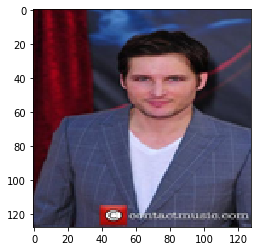

In [45]:
plt.imshow(X_test[1])

In [53]:
def draw_bbox(img, bbox):

    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img)

    # Create a Rectangle patch
    rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()

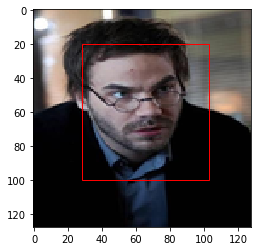

In [89]:
draw_bbox(X_test[1],Y_test[1])


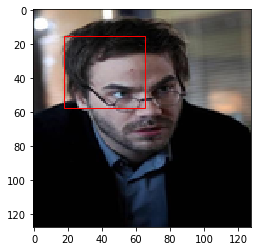

In [90]:
draw_bbox(X_test[1],y_pred[1])

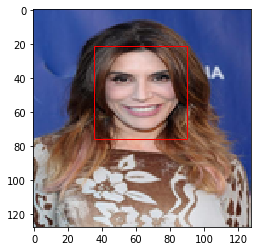

In [57]:
draw_bbox(X_test[2],Y_test[2])

In [59]:
IOU(Y_test[1], y_pred[1])

0.667020975302643

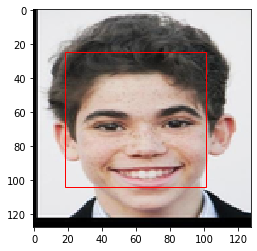

In [93]:
draw_bbox(X_test[2],y_pred[2])

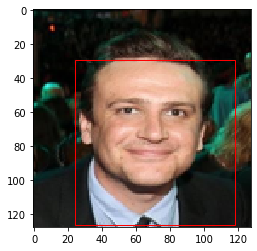

In [99]:
draw_bbox(X_test[512],y_pred[512])

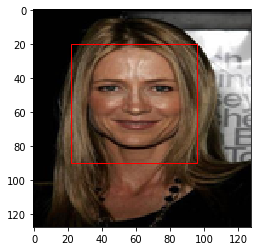

In [65]:
draw_bbox(X_test[54],Y_test[54])

In [67]:
IOU(Y_test[53], y_pred[53])

0.6210522136759873